# Project 3: Analyzing the behaviour of the word "anymore" in different geographical regions
### Submitted by: 
Siddharth Vashishtha, Liz Lee, Nick Kasper

# Data Collection:
## Scraping Comments from Reddit using Praw 

In [1]:
from collections import defaultdict
import pandas as pd
import numpy as np
import os
import re
import nltk
import matplotlib.pyplot as plt

In [2]:
#Don't run this as you would need your own password/secret codes

#This is stored locally only on MY computer
file = open('passwords')
passwords = file.readlines()
file.close()

c_id = passwords[0].strip().split("=")[-1]
c_secret = passwords[1].strip().split("=")[-1]
user = passwords[2].strip().split("=")[-1]
passw = passwords[3].strip().split("=")[-1]

# Start your instance of reddit API

In [3]:
## start your reddit API
import praw
instance=praw.Reddit(client_id=c_id,  #your client id
                     client_secret=c_secret, #your client secret
                     username=user,  #your username
                     password=passw, #your password
                     user_agent='sidvash')

# Retrieve titles, comments and replies from Reddit threads


In [4]:
def scrape_reddit(subred, word, cols):
    '''
    Input: 
        1. Subreddit_list: A list of subreddits to be scraped
        2. word: only comments/threads containing this word would be scraped
    Output:
        1. A dict with all stored commments
        2. Output a Pandas dataframes containi
    
    
    '''

    subInstance=instance.subreddit(subred)
    hotThreads=subInstance.hot(limit=2000) ## two stickies threads, skip them and only work with top hot thread

    dict_thread = {}
    dict_comment = defaultdict(list)
    count_thread=0
    count_word =0
    dataframes = []

    print("##### Processing Subreddit : {} ####\n".format(subred))

    for thread in hotThreads:
        if not thread.stickied: ## remove stickied threads
            #print(thread.title)
            if count_thread%20 == 0:
                print("Threads scraped so far: {}".format(count_thread))
                print("Count of '{}' so far: {}\n".format(word, count_word))

            #Add titles to dict_thread
            if word in thread.title.lower():
                dict_thread[count_thread] = thread.title
                count_word+=1

            thread.comments.replace_more(limit=20) ## remove all MoreComments objects

            #Add comments to the dict_comment
            for comment in thread.comments.list():
                if word in comment.body.lower():
                    dict_comment[count_thread].append(comment.body)
                    count_word +=1

            count_thread+=1
        
    data = create_dataframe(dict_thread, dict_comment, subred, cols)
        
    data.to_csv("comments_data_"+ subred + ".csv")
        
    return data
    
                   
def create_dataframe(dict_thread, dict_comment, subr, cols, index_range = 1000):
    '''
    Creates a Pandas dataframe from the given scraped data dictionary 
    '''
    data = pd.DataFrame(index = range(index_range), columns=cols)
    
    row = 0

    for thread_id, thread_title in dict_thread.items():
        data.loc[row, "subreddit"] = subr
        data.loc[row, "thread_id"] = thread_id
        data.loc[row, "body"] = thread_title
        data.loc[row, "comment_yn"] = 0
        data.loc[row, "thread_title_yn"] = 1

        row+=1

    #Store comments
    for thread_id, comments in dict_comment.items():
        for comment in comments:
            data.loc[row, "subreddit"] = subr
            data.loc[row, "thread_id"] = thread_id
            data.loc[row, "body"] = comment
            data.loc[row, "comment_yn"] = 1
            data.loc[row, "thread_title_yn"] = 0

            row+=1
    
    #Delete NAN rows
    data = data.dropna()
            
    return data

In [5]:
columns = ['subreddit', 'thread_id', 'body', 'comment_yn', 'thread_title_yn' ]

In [6]:
#Running this saves the dataset in your current directory

#This command is run for different subreddits
#data = scrape_reddit("london", "anymore", columns)

## Append all the sub-reddit datasets

In [7]:
data_path = 'Reddit_datasets_Anymore/'
data_sets = [pd.read_csv(data_path + file) for file in os.listdir(data_path)]    
combined_data = pd.concat(data_sets, ignore_index=True) 
combined_data.drop('Unnamed: 0', inplace=True, axis=1)

### Occurences of Anymore

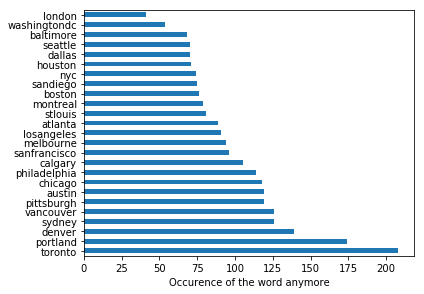

In [8]:
combined_data.subreddit.value_counts().plot(kind='barh')
plt.tight_layout()
plt.xlabel("Occurence of the word anymore")
plt.savefig("anymore_occurence.png")
plt.show()


In [9]:
print("Total occurences of the word anymore: {}".format(combined_data.shape[0]))

Total occurences of the word anymore: 2477


## Pre-Processing

#### Remove sentences which don't have "anymore" in them

In [10]:
def extract_sent(text, word):
    '''
    Given a paragraph text, extract only those
    sentences which contain the second argument 'word' in them
    '''
    list_sent = nltk.sent_tokenize(text)
    
    list_cropped = [sent for sent in list_sent if word in sent]
    
    return "".join(list_cropped)

In [11]:
combined_data["sentence"] = combined_data.body.map(lambda x: extract_sent(x, 'anymore'))

#### Remove contractions:


In [12]:
def replace_string(s):
    '''
    Make some changes to the input string,
    such as: remove contractions
    eg: can't -> can not
        didn't -> did not
        can't
        
    Limitation: ain't
    '''
    s = s.lower()
    
    s = re.sub(r"\bcan't\b", r"can not", s)
    s = re.sub(r"\bwon't\b", r"would not", s)
    s = re.sub(r"([A-z])(n['’]t)", r"\1 not", s)
    s = re.sub(r"\b(dont)\b", r"do not", s)
    s = re.sub(r"\b(cannot)\b", r"can not", s)
    s = re.sub(r"\b(cant)\b", r"can not", s)
    s = re.sub(r"\b(doesnt)\b", r"does not", s)
    s = re.sub(r"\b(wont)\b", r"would not", s)
    s = re.sub(r"\b(idk)\b", r"i do not know", s)
    s = re.sub(r"\b(arent)\b", r"are not", s)
    s = re.sub(r"\b(couldnt)\b", r"could not", s)
    s = re.sub(r"\b(didnt)\b", r"did not", s)
    s = re.sub(r"\b(isnt)\b", r"is not", s)
    s = re.sub(r"\b(aint)\b", r"is not", s)
    return s

#### Examples to check contractions

In [13]:
print(replace_string("dont do that please man"))
print(replace_string("i cant do that"))
print(replace_string("i didn't do it man, ask him"))
print(replace_string("idk what you are talking about. Dont talk to me"))

do not do that please man
i can not do that
i did not do it man, ask him
i do not know what you are talking about. do not talk to me


In [14]:
combined_data["sentence_upd"] = combined_data.sentence.map(lambda x: replace_string(x))

#### Remove blank sentences after pre-processing

In [15]:
print("{} blank sentences found".format(combined_data[combined_data.sentence_upd == ""].shape[0]))
combined_data = combined_data[combined_data.sentence_upd != ""]
print("Blank sentences removed")

18 blank sentences found
Blank sentences removed


In [16]:
combined_data

,subreddit,thread_id,body,comment_yn,thread_title_yn,sentence,sentence_upd
0,atlanta,11,Frontline isn't very effective anymore. You're...,1,0,Frontline isn't very effective anymore.,frontline is not very effective anymore.
1,atlanta,12,> Take your allergy pills!\n\nI have been curs...,1,0,I have been cursed and condemned that my body ...,i have been cursed and condemned that my body ...
2,atlanta,12,I've had a double ear infection for a month. T...,1,0,My daily allegra wasn't cutting it anymore.,my daily allegra was not cutting it anymore.
3,atlanta,12,"Yeah, it used to be funny on the rare occasion...",1,0,:C I don't toss them anymore.,:c i do not toss them anymore.
4,atlanta,15,"Honestly, I'm not butthurt over the stadium an...",1,0,"Honestly, I'm not butthurt over the stadium an...","honestly, i'm not butthurt over the stadium an..."
5,atlanta,28,I drive Lyft fulltime so I don't really have a...,1,0,I drive Lyft fulltime so I don't really have a...,i drive lyft fulltime so i do not really have ...
6,atlanta,45,I refuse to buy a new car anymore just because...,1,0,I refuse to buy a new car anymore just because...,i refuse to buy a new car anymore just because...
7,atlanta,49,We don’t need anymore traffic,1,0,We don’t need anymore traffic,we do not need anymore traffic
8,atlanta,59,I switched from t-mo to cricket recently.\n$35...,1,0,Not anymore.,not anymore.
9,atlanta,71,So my rights go out the window when others dec...,1,0,So my rights go out the window when others dec...,so my rights go out the window when others dec...


## Finding Negative/Positive Anymores

## Finding negatives within the sentence:

-  We ignore the syntactic structure of the sentences and just capture negatives before the occurence of the word "anymore".
- We use regular expression to check for these negative words
- We didn't go for parsing the sentence as we are already able to capture most of the negative anymore using this strategy

#### Presence of Overt Negatives, Question Marks and Hypothetical clauses 

In [17]:
def present_overt_neg(s, word):
    '''
    Returns True if overt negatives are present
    before the input word in the 's' string
    
    '''
    s = s.lower()
    
    set_negatives = {"not", "no", "never", "doubt(s|ed)?", "unlikely", 
                     "improbable", "dislike(s|d)?", "prevent(s|ed)?",
                    "seldom", "rarely", "scarcely", "hardly",
                    "few", "only", "if", "whether", "whatever",
                     "lest", "unless"}
    
    temp = s.split(word)
    for word in set_negatives:
        
        if bool(re.search(r"\b(not|no|never|doubt(s|ed)?|unlikely)|barely|improbable|dislike(s|d)?|prevent(s|ed)?|seldom|rarely|scarcely|hardly|few|only|if|whether|whatever|lest|unless\b", temp[0])):
            return True
        
        elif bool(re.search(r"\?", s)):
            return True
    
        else:
            continue
    
    return False

In [18]:
#Example test:
present_overt_neg("i do it anymore?", "anymore")

True

In [19]:

combined_data["negative_anymore"] = combined_data.sentence_upd.map(lambda x: present_overt_neg(x, "anymore"))

In [20]:
print("Presence of positive anymores : {}".format(combined_data[combined_data.negative_anymore==False].shape[0]))

Presence of positive anymores : 65


#### Let's look at the examples that we classify as positive anymores

In [21]:
combined_data[combined_data.negative_anymore==False][['subreddit', 'sentence_upd']].values

array([['atlanta',
        'i refuse to buy a new car anymore just because of having to go through a car dealership (and most are crap until they survive a few thousand miles).'],
       ['melbourne', 'who cares anymore.'],
       ['melbourne',
        'for the record i vote state liberal, federal labor because labor have left a bad taste in my mouth too many times over for me to trust the state version anymore.'],
       ['pittsburgh',
        'most major banks will do this or some variation of this anymore, or itll just be done through the app.'],
       ['pittsburgh',
        'way too many colleges have graphic design programs when there’s little need for them anymore in practice since adobe photoshop and indesign are nearly as ubiquitous as word and excel nowadays.'],
       ['pittsburgh',
        "it's definitely a stretch to call it blue collar anymore, and i do not mean to imply it should remain blue collar, but i associate it with the region's characteristic humility and friend

## Distribution of Positive Anymore

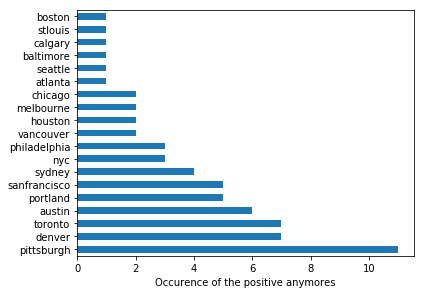

In [22]:
combined_data[combined_data.negative_anymore==False]['subreddit'].value_counts().plot(kind='barh')
plt.tight_layout()
plt.xlabel("Occurence of the positive anymores")
plt.savefig("positive_anymore_occurence.png")
plt.show()


# Discussion

Please read the write-up to read discussion and conclusions
